FOCI-OpenIFS with VIKING10 nest
===============================

Run OpenIFS T159 or T799 with NEMO ORCA05 with/without VIKING10 nest.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 

In [17]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 8 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 750 MiB of memory each.
cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit=750e6,
                       silence_logs=50)
client = Client(address=cluster)

/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [18]:
client

<Client: 'tcp://127.0.0.1:35698' processes=8 threads=8, memory=6.00 GB>

In [19]:
esmdir = '/sfs/fs1/work-geomar/smomw352/foci_analysis/'
runs = ['foci_JJK001_pmpi','foci_JJK002_29','foci_JJK005_6','foci_JJK006_3']
runname = ['FOCI-LL','FOCI-LH','FOCI-HH','FOCI-HL']

name_ll = 'foci_JJK001_pmpi'
name_lh = 'foci_JJK002_29'
name_hl = 'foci_JJK006_3'
name_hh = 'foci_JJK005_6'

Make a first example plot (snapshot)

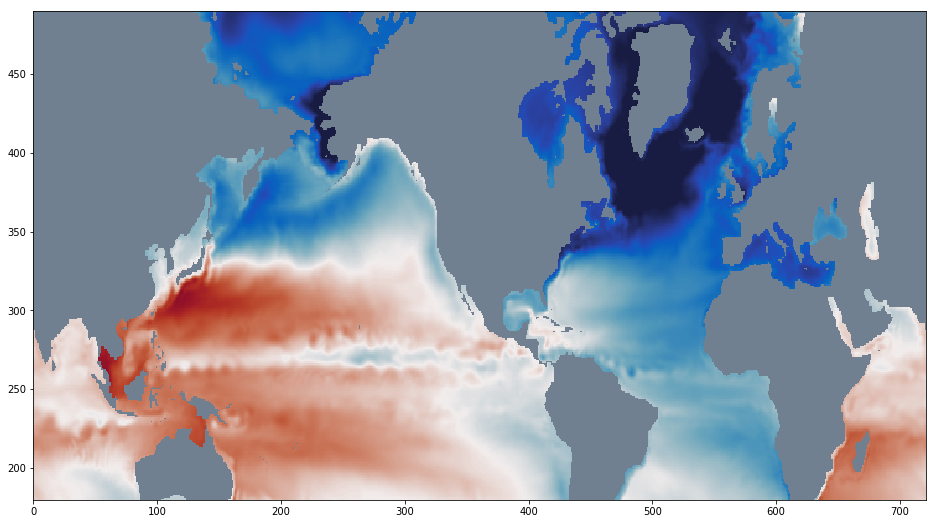

In [173]:
lnest = False

#ex_dir = '/sfs/fs1/work-geomar/smomw352/esm-experiments/foci_JJK002_29/outdata/nemo'
#ex_base = '%s/foci_JJK002_29_5d_19490101_19491231_grid_T.nc' % (ex_dir,)
ex_dir = '/sfs/fs1/work-geomar/smomw352/esm-experiments/foci_JJK001_pmpi/outdata/nemo/'
ex_base = '%s/foci_JJK001_pmpi_5d_19400101_19491231_grid_T.nc' % (ex_dir,)

ds_base = xr.open_dataset(ex_base)
ex_var = 'sossheig'
ex_base_lons = ds_base['nav_lon'].values
ex_base_lats = ds_base['nav_lat'].values
ex_base_data = ds_base[ex_var].isel(time_counter=657).values
ex_base_data = np.ma.masked_where( ex_base_data == 0, ex_base_data )

ex_base_ny,ex_base_nx = ex_base_data.shape
ex_base_i = np.arange(0,ex_base_nx)
ex_base_j = np.arange(0,ex_base_ny)

clevels = np.linspace(-1,1,101)
cmap = cmocean.cm.balance

if lnest:
    ex_nest = '%s/1_foci_JJK002_29_5d_19490101_19491231_grid_T.nc' % (ex_dir,)
    ds_nest = xr.open_dataset(ex_nest)
    ex_nest_lons = ds_nest['nav_lon'].values
    ex_nest_lats = ds_nest['nav_lat'].values
    # Cut away first and last two indices (these are fillers in AGRIF)
    ex_nest_data = ds_nest[ex_var].isel(time_counter=0).values[2:-2,2:-2]
    ex_nest_data = np.ma.masked_where( ex_nest_data == 0, ex_nest_data )
    ex_nest_ny,ex_nest_nx = ex_nest_data.shape
    ex_nest_i = np.arange(0,ex_nest_nx)/5. + 410 
    ex_nest_j = np.arange(0,ex_nest_ny)/5. + 314
    print(ex_nest_i.shape,ex_nest_j.shape,ex_nest_data.shape)

if 1:
    # Quick and dirty solution: Use model coordinates 
    fig, ax = plt.subplots(1,1,figsize=(16,9))
    ax.set_facecolor('slategrey')
    #cf1 = ax.contourf(ex_base_i, ex_base_j, ex_base_data, cmap=cmap, levels=clevels, extend='both')
    #cf2 = ax.contourf(ex_nest_i, ex_nest_j, ex_nest_data, cmap=cmap, levels=clevels, extend='both')
    ax.pcolormesh(ex_base_i, ex_base_j, ex_base_data, cmap=cmap, vmin=-1, vmax=1)
    
    if lnest:
        ax.pcolormesh(ex_nest_i, ex_nest_j, ex_nest_data, cmap=cmap, vmin=-1, vmax=1)
        ax.plot([ex_nest_i[0],ex_nest_i[-1]],[ex_nest_j[0],ex_nest_j[0]],'-k')
        ax.plot([ex_nest_i[0],ex_nest_i[-1]],[ex_nest_j[-1],ex_nest_j[-1]],'-k')
        ax.plot([ex_nest_i[0],ex_nest_i[0]],[ex_nest_j[0],ex_nest_j[-1]],'-k')
        ax.plot([ex_nest_i[-1],ex_nest_i[-1]],[ex_nest_j[0],ex_nest_j[-1]],'-k')
    
    #ax.set_xlim([400,600])
    ax.set_ylim([180,490])

if 0:
    fig = plt.figure(figsize=(9,16))
    proj = projection=ccrs.PlateCarree(central_longitude=0)
    map_extent = [-90, 30, -30, 85]
    
    x, y, _ = proj.transform_points(ccrs.PlateCarree(), ex_base_lons.flatten(), ex_base_lats.flatten()).T
    mask = np.invert(np.logical_or(np.isinf(x), np.isinf(y)))
    x = np.compress(mask, x)
    y = np.compress(mask, y)
    ax = plt.axes(projection=proj)
    ax.tricontourf(x, y, ex_base_data.flatten()[mask], levels=clevels, cmap=cmap, extend='both' )
    #ax.tripcolor(x, y, ex_base_data.flatten()[mask], vmin=-1, vmax=1, cmap=cmap )
    
    x, y, _ = proj.transform_points(ccrs.PlateCarree(), ex_nest_lons.flatten(), ex_nest_lats.flatten()).T
    mask = np.invert(np.logical_or(np.isinf(x), np.isinf(y)))
    x = np.compress(mask, x)
    y = np.compress(mask, y)
    ax.tricontourf(x, y, ex_nest_data.flatten()[mask], levels=clevels, cmap=cmap, extend='both' )
    #ax.tripcolor(x, y, ex_nest_data.flatten()[mask], vmin=-1, vmax=1, cmap=cmap )
    #ax.pcolor(ex_base_lons, ex_base_lats, ex_base_data, vmin=-1, vmax=1, cmap=cmap, transform=ccrs.PlateCarree())
    
    #ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black')
    ax.set_extent(map_extent,ccrs.PlateCarree())
    ax.coastlines()
    
fig.savefig('snapshot_viking10.png',format='png',dpi=600)

<xarray.DataArray 'T2M' (lat: 160, lon: 320)>
array([[244.95982, 244.99004, 245.02025, ..., 244.87743, 244.90489, 244.93236],
       [245.26256, 245.32741, 245.39226, ..., 244.98286, 245.0761 , 245.16933],
       [243.99889, 243.98965, 243.98042, ..., 243.93166, 243.95406, 243.97647],
       ...,
       [252.93443, 252.87796, 252.82149, ..., 253.32137, 253.1924 , 253.06342],
       [254.5067 , 254.46062, 254.41454, ..., 254.6779 , 254.62083, 254.56377],
       [254.98717, 254.96674, 254.9463 , ..., 255.0399 , 255.02232, 255.00475]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 1941-01-01T12:00:00
  * lon      (lon) float32 0.0 1.125 2.25 3.375 ... 355.5 356.625 357.75 358.875
  * lat      (lat) float32 89.14152 88.02943 86.910774 ... -88.02943 -89.14152
Attributes:
    long_name:  2 metre temperature
    units:      K
    code:       167
    table:      128
<xarray.DataArray 'T2M' (lat: 800, lon: 1600)>
[1280000 values with dtype=float32]
Coordinates:
    time     date

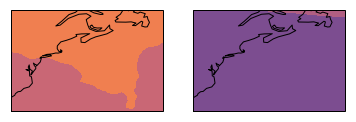

In [5]:
#
# Plot snapshot from OpenIFS
# 
ex_dir = '/sfs/fs1/work-geomar/smomw352/esm-experiments/foci_JJK002_29/outdata/oifs/'
ex_lr = '%s/foci_JJK002_29_19410101_19411231_GG_surface.nc' % (ex_dir,)
ex_dir = '/sfs/fs1/work-geomar/smomw352/esm-experiments/foci_JJK005_6/outdata/oifs/'
ex_hr = '%s/foci_JJK005_6_19410101_19411231_GG_surface.nc' % (ex_dir,)

ds_lr = xr.open_dataset(ex_lr)
ds_hr = xr.open_dataset(ex_hr)

cmap = cmocean.cm.thermal
map_extent = [-80, -50, 30, 50]

ax = plt.subplot(121, projection=ccrs.PlateCarree(central_longitude=0))
zplot = ds_lr['T2M'].isel(time=0)
print(zplot)
cf = ax.contourf(zplot,cmap=cmap)
ax.set_extent(map_extent,ccrs.PlateCarree())
ax.coastlines()

ax = plt.subplot(122, projection=ccrs.PlateCarree(central_longitude=0))
zplot = ds_hr['T2M'].isel(time=0)
print(zplot)
cf = ax.contourf(zplot,cmap=cmap)
ax.set_extent(map_extent,ccrs.PlateCarree())
ax.coastlines()


fig = plt.gcf()
fig.savefig('oifs_example.png',format='png',dpi=600)

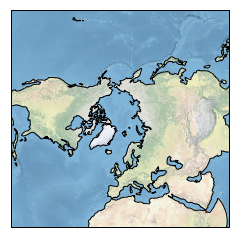

In [20]:
# Map projection
if 0:
    central_lon, central_lat = -10, 50
    #map_extent = [-30, 50, 25, 80]
    map_extent = [-179,180,-85,90]
    map_prj = ccrs.PlateCarree(central_longitude=central_lon)
if 0:
    map_prj = ccrs.LambertConformal(central_longitude=-96.0, central_latitude=39.0, 
                                    false_easting=0.0, false_northing=0.0, 
                                    secant_latitudes=None, standard_parallels=None, 
                                    globe=None, cutoff=0)
if 0:
    map_prj = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=50, 
                                       satellite_height=35785831, 
                                       false_easting=0, false_northing=0, globe=None)
if 1:
    map_extent = [-180,180,20,90]
    map_prj = ccrs.NorthPolarStereo(central_longitude=0.0, globe=None)
    
plt.figure()
ax = plt.axes(projection=map_prj)
ax.set_extent(map_extent,ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

Plot differences in surface fields

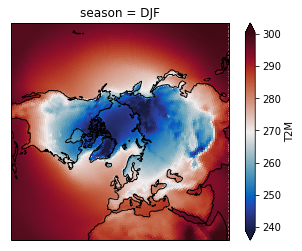

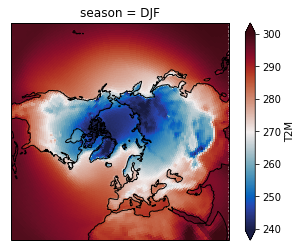

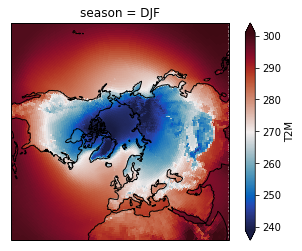

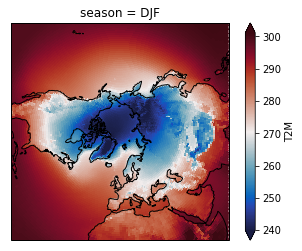

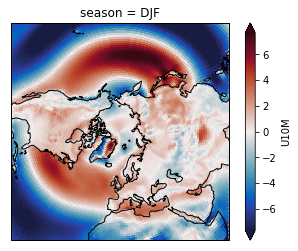

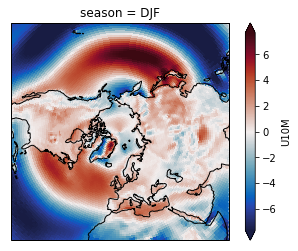

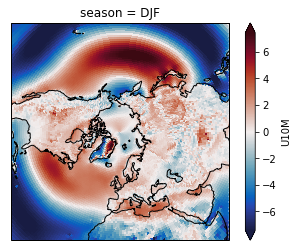

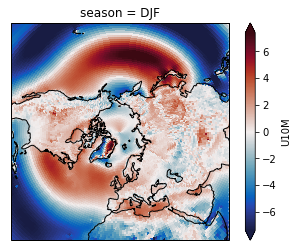

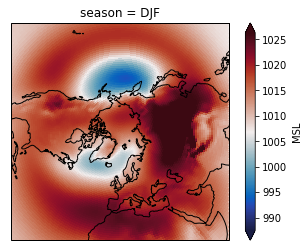

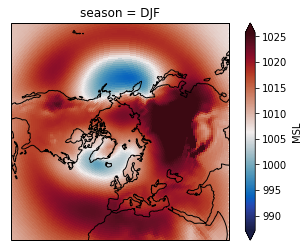

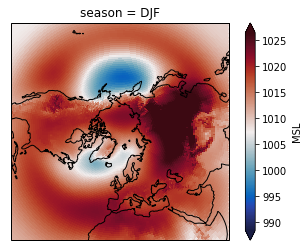

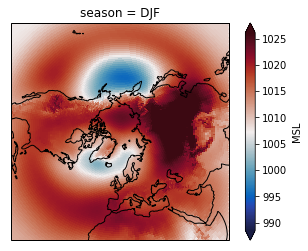

In [38]:
for var in ['T2M','U10M','MSL']:
    for run in [name_ll, name_lh, name_hl, name_hh]:
        file = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,run)
        ds = xr.open_dataset(file)
        
        cmap = cmocean.cm.balance
        clevels = np.arange(0,110,10)
        
        tp = ds[var]
        if var == 'TP':
            scale = 2000
        elif var == 'MSL':
            scale = 0.01
        else:
            scale = 1
            
        zplot = tp.groupby('time.season').mean('time') * scale
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        zplot.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                             robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        fig = plt.gcf()
        fig.savefig('%s_mean_%s.png' % (var,run),format='png',dpi=600)

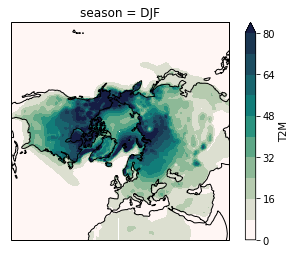

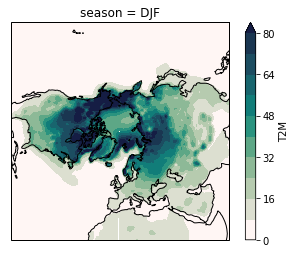

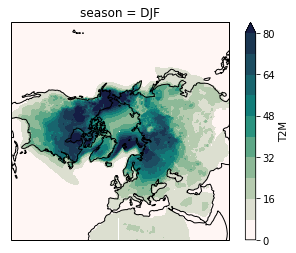

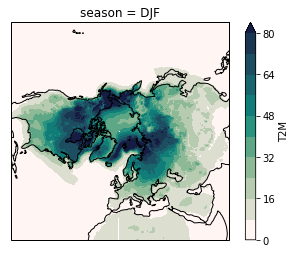

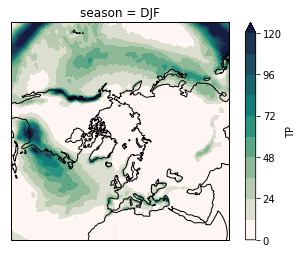

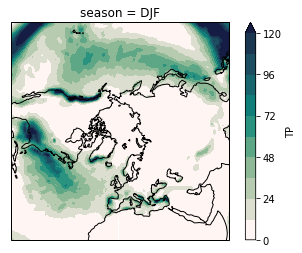

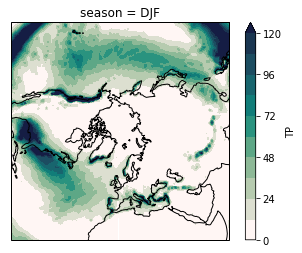

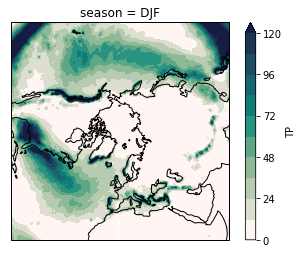

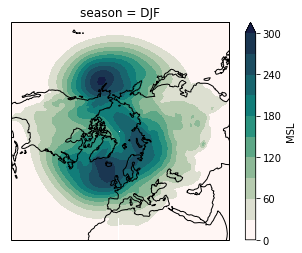

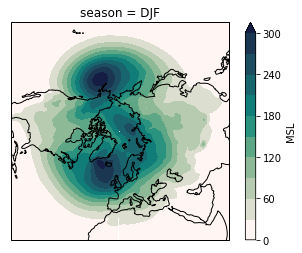

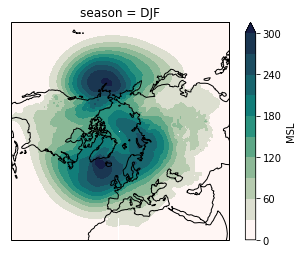

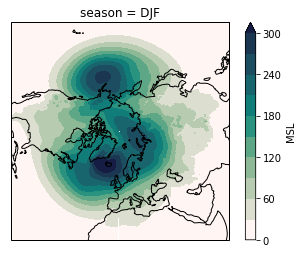

In [37]:
cmap = cmocean.cm.tempo
for var in ['T2M','TP','MSL']:
    for run in [name_ll, name_lh, name_hl, name_hh]:
        file = '%s/%s_1d_19500101_19791231_GG_surface_yseasvar.nc' % (esmdir,run)
        ds = xr.open_dataset(file)
        
        #cmap = cmocean.cm.balance
        
        tp = ds[var]
        if var == 'TP':
            scale = 2000**2
            clevels = np.linspace(0,120,11)
        elif var == 'MSL':
            scale = 0.01**2
            clevels = np.linspace(0,300,11)
        elif var == 'T2M':
            scale = 1
            clevels = np.linspace(0,80,11)
            
        zplot = tp.groupby('time.season').mean('time') * scale
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        zplot.isel(season=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                           levels=clevels)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        fig = plt.gcf()
        fig.savefig('%s_daily_variance_%s.png' % (var,run),format='png',dpi=600)

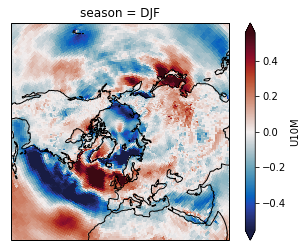

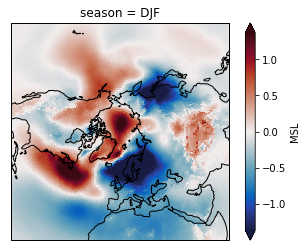

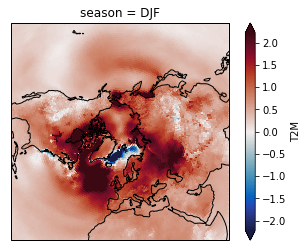

In [42]:
for var in ['U10M','MSL','T2M']:
    if 1:
        file_ll = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_ll)
        file_lh = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_lh)
        file_hl = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_hl)
        file_hh = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_hh)
        
        ds_ll = xr.open_dataset(file_ll)
        ds_lh = xr.open_dataset(file_lh)
        ds_hl = xr.open_dataset(file_hl)
        ds_hh = xr.open_dataset(file_hh)
        
        cmap = cmocean.cm.balance
        
        if var == 'TP':
            scale = 2000
        elif var == 'MSL':
            scale = 0.01
        else:
            scale = 1
        
        data_ll = ds_ll[var].groupby('time.season').mean('time') * scale
        data_lh = ds_lh[var].groupby('time.season').mean('time') * scale
        data_hl = ds_hl[var].groupby('time.season').mean('time') * scale
        data_hh = ds_hh[var].groupby('time.season').mean('time') * scale
        
        # Differences due to nest
        diff_hatm = data_hh - data_hl 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        fig = plt.gcf()
        fig.savefig('%s_mean_%s-%s.png' % (var,name_hh,name_hl),format='png',dpi=600)

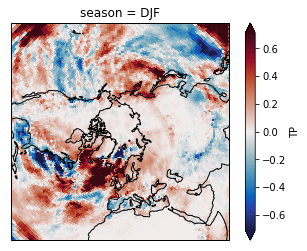

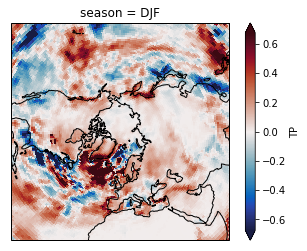

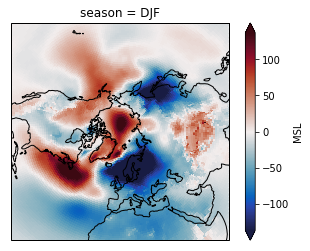

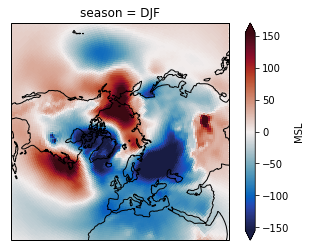

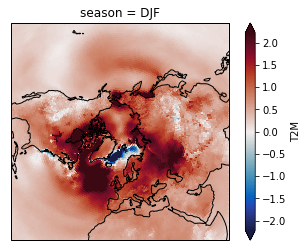

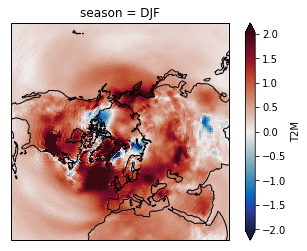

In [21]:
for var in ['TP','MSL','T2M']:
    if 1:
        file_ll = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_ll)
        file_lh = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_lh)
        file_hl = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_hl)
        file_hh = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_hh)
        
        ds_ll = xr.open_dataset(file_ll)
        ds_lh = xr.open_dataset(file_lh)
        ds_hl = xr.open_dataset(file_hl)
        ds_hh = xr.open_dataset(file_hh)
        
        cmap = cmocean.cm.balance
        
        if var == 'TP':
            scale = 2000
        else:
            scale = 1
        
        data_ll = ds_ll[var].groupby('time.season').mean('time') * scale
        data_lh = ds_lh[var].groupby('time.season').mean('time') * scale
        data_hl = ds_hl[var].groupby('time.season').mean('time') * scale
        data_hh = ds_hh[var].groupby('time.season').mean('time') * scale
        
        # Differences due to nest, high-res atm
        diff_hatm = data_hh - data_hl 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        
        fig = plt.gcf()
        fig.savefig('%s_mean_%s-%s.png' % (var,name_hh,name_hl),format='png',dpi=600)
        
        
        # Differences due to nest, low-res atm
        diff_hatm = data_lh - data_ll 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        
        fig = plt.gcf()
        fig.savefig('%s_mean_%s-%s.png' % (var,name_lh,name_ll),format='png',dpi=600)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


IndexError: index -1 is out of bounds for axis 0 with size 0

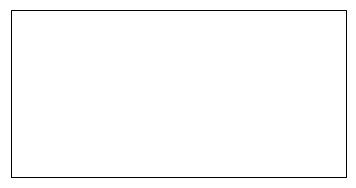

In [9]:
for var in ['TP','MSL','T2M']:
    if 1:
        file_ll = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_ll)
        file_lh = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_lh)
        file_hl = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_hl)
        file_hh = '%s/%s_19500101_19791231_GG_surface_yseasmean.nc' % (esmdir,name_hh)
        
        ds_ll = xr.open_dataset(file_ll)
        ds_lh = xr.open_dataset(file_lh)
        ds_hl = xr.open_dataset(file_hl)
        ds_hh = xr.open_dataset(file_hh)
        
        cmap = cmocean.cm.balance
        
        if var == 'TP':
            scale = 2000
        else:
            scale = 1
        
        data_ll = ds_ll[var].groupby('time.season').mean('time') * scale
        data_lh = ds_lh[var].groupby('time.season').mean('time') * scale
        data_hl = ds_hl[var].groupby('time.season').mean('time') * scale
        data_hh = ds_hh[var].groupby('time.season').mean('time') * scale
        
        # Differences due to atm resolution, with nest
        data_hh['lat'].values = data_lh['lat'].values
        data_hl['lat'].values = data_lh['lat'].values
        data_ll['lat'].values = data_lh['lat'].values
        print(data_hh['lat'].values - data_lh['lat'].values)
        diff_hatm = data_hh - data_lh 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        
        fig = plt.gcf()
        fig.savefig('%s_mean_%s-%s.png' % (var,name_hh,name_hl),format='png',dpi=600)
        
        
        # Differences due to atm resolution, no nest
        diff_hatm = data_hl - data_ll 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        
        fig = plt.gcf()
        fig.savefig('%s_mean_%s-%s.png' % (var,name_lh,name_ll),format='png',dpi=600)

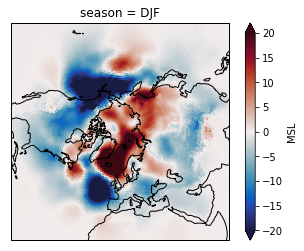

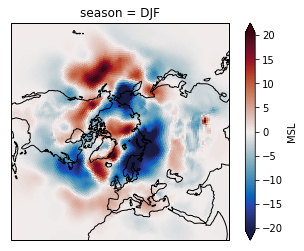

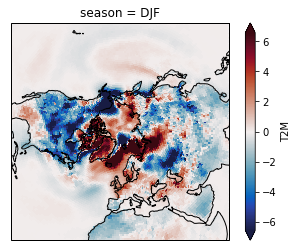

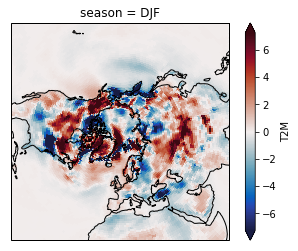

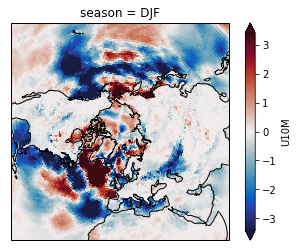

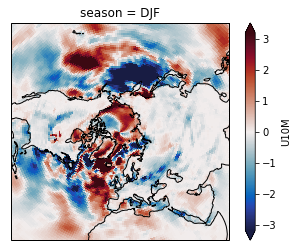

In [22]:
cmap = cmocean.cm.diff

for var in ['MSL','T2M','U10M']:
    if 1:
        file_ll = '%s/%s_1d_19500101_19791231_GG_surface_yseasvar.nc' % (esmdir,name_ll)
        file_lh = '%s/%s_1d_19500101_19791231_GG_surface_yseasvar.nc' % (esmdir,name_lh)
        file_hl = '%s/%s_1d_19500101_19791231_GG_surface_yseasvar.nc' % (esmdir,name_hl)
        file_hh = '%s/%s_1d_19500101_19791231_GG_surface_yseasvar.nc' % (esmdir,name_hh)
        
        ds_ll = xr.open_dataset(file_ll)
        ds_lh = xr.open_dataset(file_lh)
        ds_hl = xr.open_dataset(file_hl)
        ds_hh = xr.open_dataset(file_hh)
        
        cmap = cmocean.cm.balance
        
        if var == 'TP':
            scale = 2000
        elif var == 'MSL':
            scale = 0.01
        else:
            scale = 1
        
        data_ll = ds_ll[var].groupby('time.season').mean('time') * scale**2
        data_lh = ds_lh[var].groupby('time.season').mean('time') * scale**2
        data_hl = ds_hl[var].groupby('time.season').mean('time') * scale**2
        data_hh = ds_hh[var].groupby('time.season').mean('time') * scale**2
        
        # Differences due to nest, high-res atm
        diff_hatm = data_hh - data_hl 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        
        fig = plt.gcf()
        fig.savefig('%s_daily_variance_%s-%s.png' % (var,name_hh,name_hl),format='png',dpi=600)
        
        # Differences due to nest, low-res atm
        diff_hatm = data_lh - data_ll 
        
        fig = plt.figure()
        ax = plt.axes(projection=map_prj)
        
        diff_hatm.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                                 robust=True)
        ax.coastlines()
        ax.set_extent(map_extent,ccrs.PlateCarree())
        
        fig = plt.gcf()
        fig.savefig('%s_daily_variance_%s-%s.png' % (var,name_hh,name_hl),format='png',dpi=600)

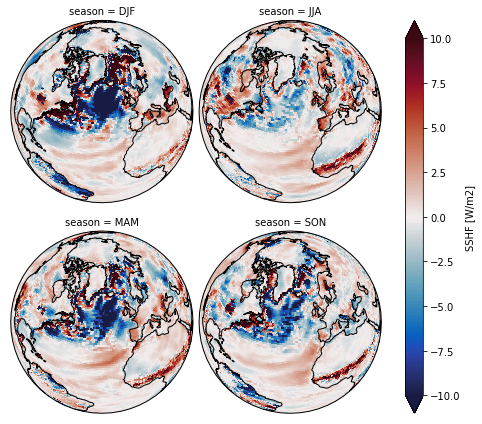

In [180]:
# Heat fluxes: 
# SSHF - Surface sens heat flux
# SLHF - Surface lat heat flux

cmap = cmocean.cm.balance

sshf_lrb = ds_lrb_mean['SSHF'] / (43200)
sshf_lra = ds_lra_mean['SSHF'] / (43200)
zplot = (sshf_lra-sshf_lrb).groupby('time.season').mean('time') 
p = zplot.plot(transform=ccrs.PlateCarree(),
               col='season', col_wrap=2,
               subplot_kws={'projection': map_prj},
               size=3, robust=True, cmap=cmap, vmin=-10, vmax=10, 
               cbar_kwargs={"label": 'SSHF [W/m2]'})
    
for ax in p.axes.flat:
    ax.coastlines()
    #ax.set_extent(map_extent, ccrs.PlateCarree())
    

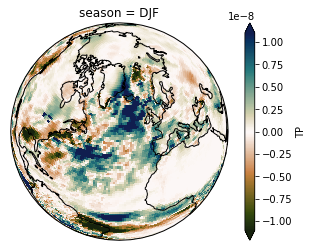

In [207]:
cmap = cmocean.cm.tarn

tp_lrb = ds_lrb_mean['TP'] / (43200)
tp_lra = ds_lra_mean['TP'] / (43200)
zplot = (tp_lra-tp_lrb).groupby('time.season').mean('time') 

if 0:
    p = zplot.plot(transform=ccrs.PlateCarree(),
                   col='season', col_wrap=2,
                   subplot_kws={'projection': map_prj},
                   size=3, robust=True, cmap=cmap, 
                   cbar_kwargs={"label": 'Tot. precip. [mm/day]'})
    for ax in p.axes.flat:
        ax.coastlines()
        #ax.set_extent(map_extent, ccrs.PlateCarree())

if 1:
    ax = plt.axes(projection=map_prj)
    zplot.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                        robust=True)
    ax.coastlines()
    
fig = plt.gcf()
fig.savefig('tp_mean_diff.png',format='png',dpi=600)

In [249]:
file_lra_mean = '%s/foci_JJK002_29_19400101_19441231_GG_surface_yseasmean.nc' % (esmdir,)
file_hra_mean = '%s/foci_JJK005_6_19400101_19441231_GG_surface_yseasmean_N80.nc' % (esmdir,)

ds_lra_mean = xr.open_dataset(file_lra_mean)
ds_hra_mean = xr.open_dataset(file_hra_mean)

file_lra_var = '%s/foci_JJK002_29_19400101_19441231_GG_surface_yseasvar.nc' % (esmdir,)
file_hra_var = '%s/foci_JJK005_6_19400101_19441231_GG_surface_yseasvar_N80.nc' % (esmdir,)

#ds_lra_var = xr.open_dataset(file_lra_var)    
#ds_hra_var = xr.open_dataset(file_hra_var)

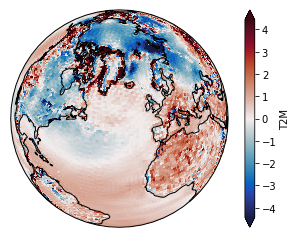

In [254]:
#
# 2m air temp
#
cmap = cmocean.cm.balance
clevels = np.arange(0,110,10)

t2m_lra = ds_lra_mean['T2M']
t2m_hra = ds_hra_mean['T2M']
zplot = (t2m_hra-t2m_lra).groupby('time.season').mean('time')    

if 0:
    p = zplot.plot(transform=ccrs.PlateCarree(),
                   col='season', col_wrap=2,
                   subplot_kws={'projection': map_prj},
                   robust=True, cmap=cmap,
                   cbar_kwargs={"label": 'T2m [K]'})
    for ax in p.axes.flat:
        ax.coastlines()
        #ax.set_extent(map_extent, ccrs.PlateCarree())

if 1:
    ax = plt.axes(projection=map_prj)
    zplot = (t2m_hra.isel(time=0) - t2m_lra.isel(time=0))
    zplot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                         robust=True)
    ax.coastlines()
        
fig = plt.gcf()
fig.savefig('t2m_mean_diff_2.png',format='png',dpi=600)


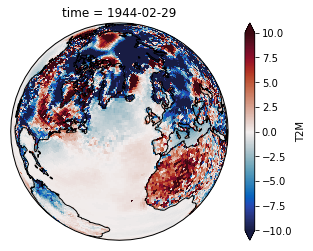

In [271]:
#
# 2m air temp var
#
cmap = cmocean.cm.balance
clevels = np.arange(0,110,10)

t2m_lra = ds_lra_var['T2M']
t2m_hra = ds_hra_var['T2M']
zplot = (t2m_hra-t2m_lra).groupby('time.season').mean('time')    

if 0:
    p = zplot.plot(transform=ccrs.PlateCarree(),
                   col='season', col_wrap=2,
                   subplot_kws={'projection': map_prj},
                   robust=True, cmap=cmap,
                   cbar_kwargs={"label": 'T2m [K]'})
    for ax in p.axes.flat:
        ax.coastlines()
        #ax.set_extent(map_extent, ccrs.PlateCarree())

if 1:
    ax = plt.axes(projection=map_prj)
    zplot = (t2m_hra.isel(time=0) - t2m_lra.isel(time=0))
    zplot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                         vmin=-10,vmax=10)
    ax.coastlines()
        
fig = plt.gcf()
fig.savefig('t2m_var_diff_2.png',format='png',dpi=600)

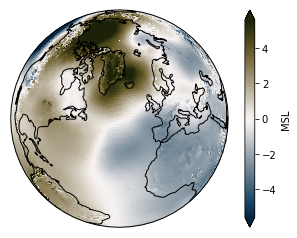

In [259]:
#
# MSLP
#
cmap = cmocean.cm.diff
clevels = np.arange(0,110,10)

msl_lra = ds_lra_mean['MSL']
msl_hra = ds_hra_mean['MSL']
zplot = (msl_hra-msl_lra).groupby('time.season').mean('time') * 1e-2

if 0:
    p = zplot.plot(transform=ccrs.PlateCarree(),
                   col='season', col_wrap=2,

                   subplot_kws={'projection': map_prj},
                   size=3, robust=True, cmap=cmap,
                   cbar_kwargs={"label": 'MSLP [hPa]'})
    
    for ax in p.axes.flat:
        ax.coastlines()
        #ax.set_extent(map_extent, ccrs.PlateCarree())

if 1:
    ax = plt.axes(projection=map_prj)
    zplot = (msl_hra.isel(time=0) - msl_lra.isel(time=0)) * 1e-2
    zplot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                        robust=True)
    ax.coastlines()
    
fig = plt.gcf()
fig.savefig('msl_mean_diff_2.png',format='png',dpi=600)

In [261]:
#
# MSLP var
#
cmap = cmocean.cm.balance
clevels = np.arange(0,110,10)

if 1:
    msl_lra = ds_lra_var['MSL']
    msl_hra = ds_hra_var['MSL']
    zplot = (msl_hra-msl_lra).groupby('time.season').mean('time') * 1e-4
    
    if 0:
        p = zplot.plot(transform=ccrs.PlateCarree(),
                       col='season', col_wrap=2,
                       subplot_kws={'projection': map_prj},
                       size=3, robust=True, cmap=cmap,
                       cbar_kwargs={"label": 'MSLP [hPa**2]'})
        
        for ax in p.axes.flat:
            ax.coastlines()
            #ax.set_extent(map_extent, ccrs.PlateCarree())
    
    if 1:
        ax = plt.axes(projection=map_prj)
        zplot = (msl_hra.isel(time=0) - msl_lra.isel(time=0)) * 1e-4
        zplot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                            robust=True)
        ax.coastlines()
        
    fig = plt.gcf()
    fig.savefig('msl_var_diff_2.png',format='png',dpi=600)

NameError: name 'ds_hra_var' is not defined

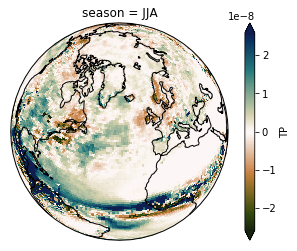

In [223]:
#
# Precip
#

cmap = cmocean.cm.tarn

tp_lra = ds_lra_mean['TP'] / (43200)
tp_hra = ds_hra_mean['TP'] / (43200)
zplot = (tp_hra-tp_lra).groupby('time.season').mean('time') 

if 0:
    p = zplot.plot(transform=ccrs.PlateCarree(),
                   col='season', col_wrap=2,
                   subplot_kws={'projection': map_prj},
                   size=3, robust=True, cmap=cmap, 
                   cbar_kwargs={"label": 'Tot. precip. [mm/day]'})
    for ax in p.axes.flat:
        ax.coastlines()
        #ax.set_extent(map_extent, ccrs.PlateCarree())

if 1:
    ax = plt.axes(projection=map_prj)
    zplot.isel(season=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                                        robust=True)
    ax.coastlines()
    
fig = plt.gcf()
fig.savefig('tp_mean_diff_2.png',format='png',dpi=600)
